In [1]:
from dataset import Dataset, Instance

data = Dataset()
data.readall("../dataset/")

instances = [
    instance
    for instance in data.instances.values()
    if instance.task.max_evaluations == 250 and instance.task.convergence_threshold == 1e-6
]
print(f"Total dataset size: {len(instances)}")

EOFError reading .gitkeep!
Total dataset size: 1959


('sim01', 4, 3): 104 instances
('sim02', 4, 3): 103 instances
('sim03', 4, 3): 121 instances
('sim04', 4, 3): 102 instances
('sim05', 4, 3): 101 instances
('sim06', 4, 3): 101 instances
('sim07', 4, 3): 101 instances
('sim08', 4, 3): 101 instances
('sim09', 4, 3): 104 instances
('sim10', 4, 3): 104 instances
('sim11', 4, 3): 103 instances
('sim12', 4, 3): 102 instances
('sim13', 4, 3): 101 instances
('sim14', 4, 3): 101 instances
('sim15', 4, 3): 103 instances
('sim16', 4, 3): 101 instances
('sim17', 4, 3): 103 instances
('sim18', 4, 3): 101 instances
('sim19', 4, 3): 102 instances


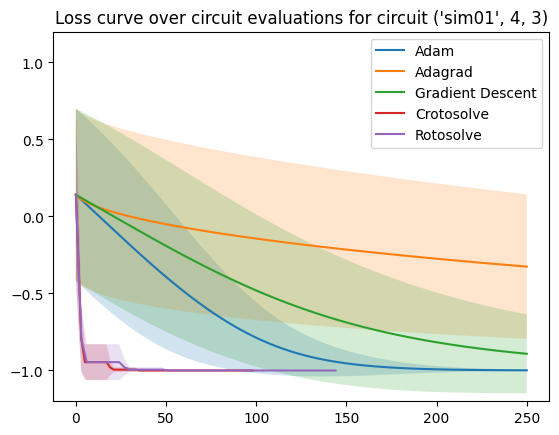

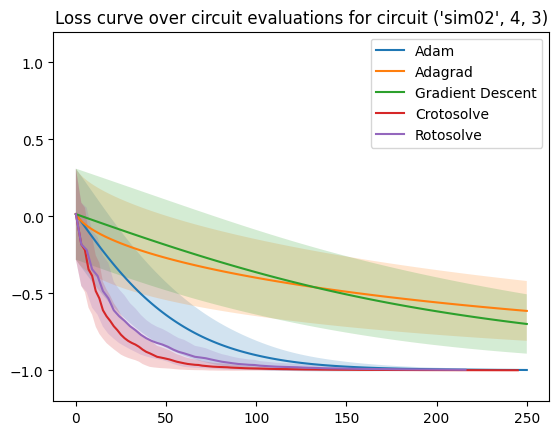

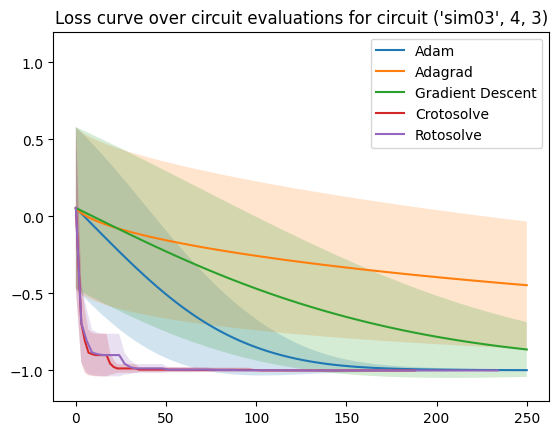

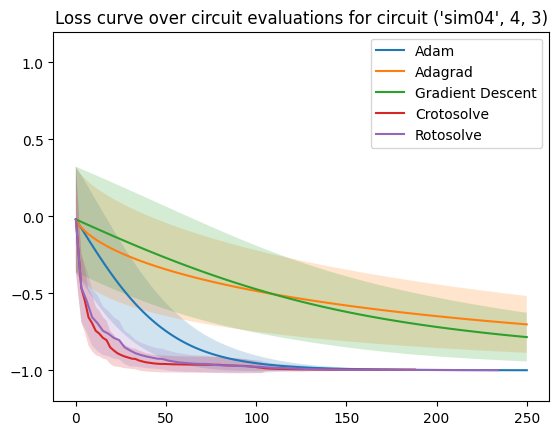

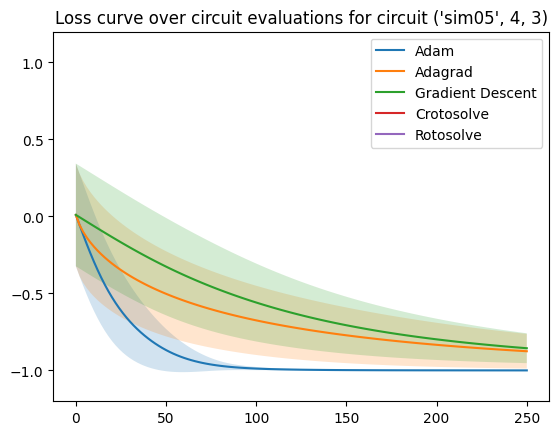

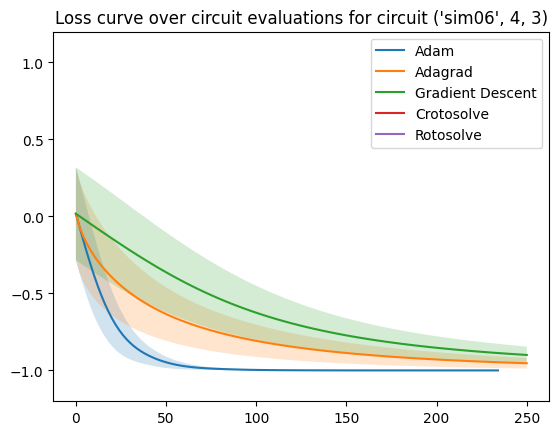

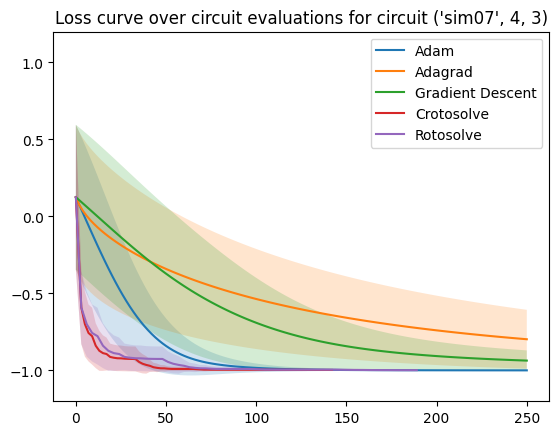

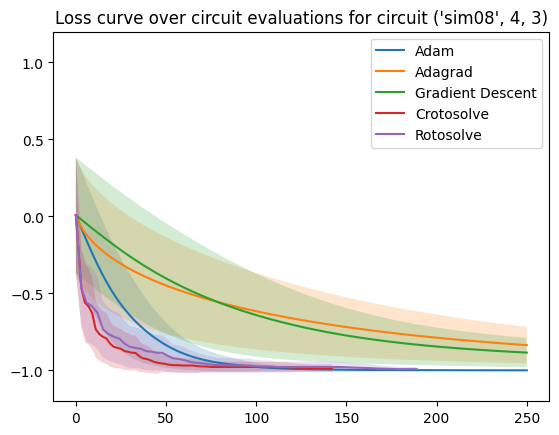

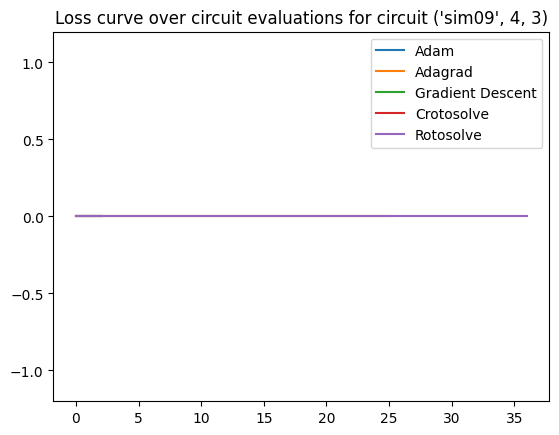

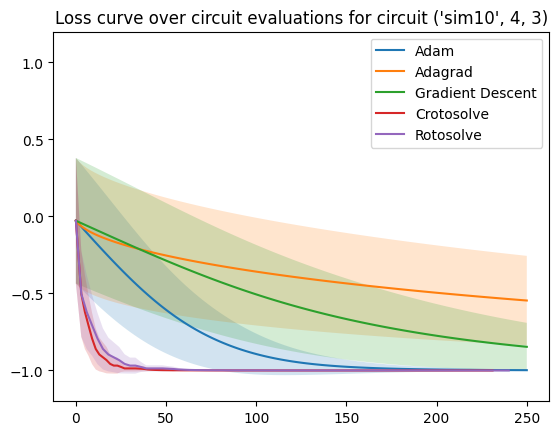

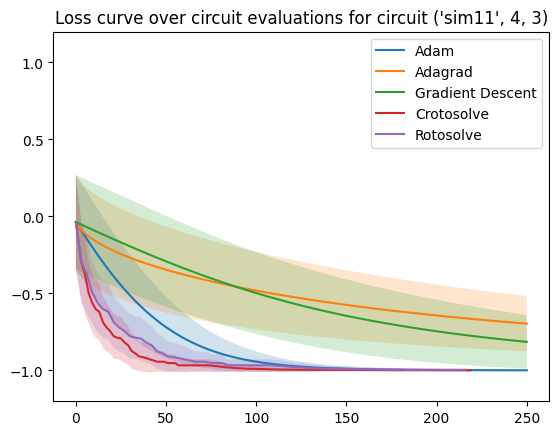

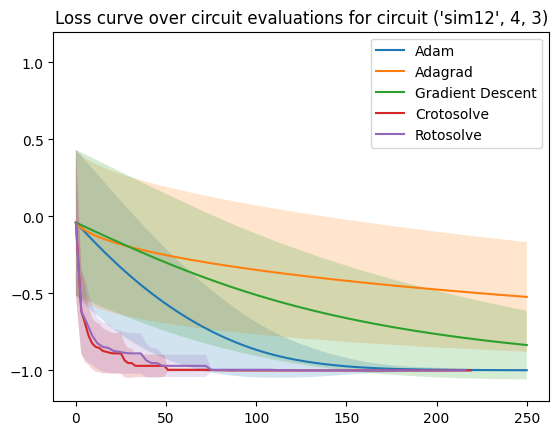

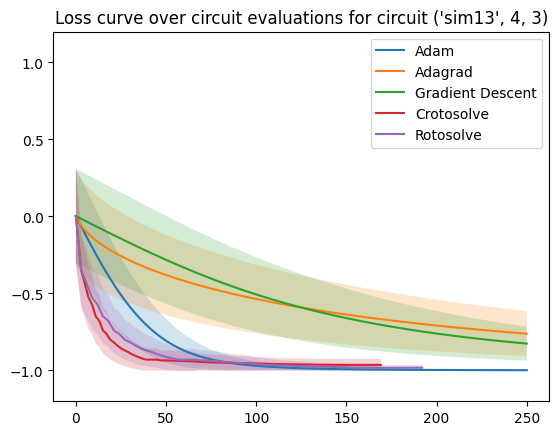

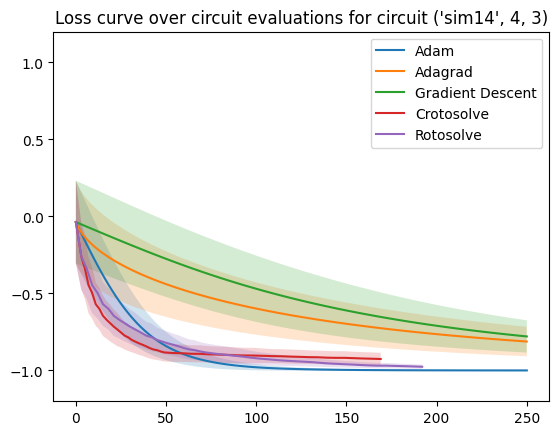

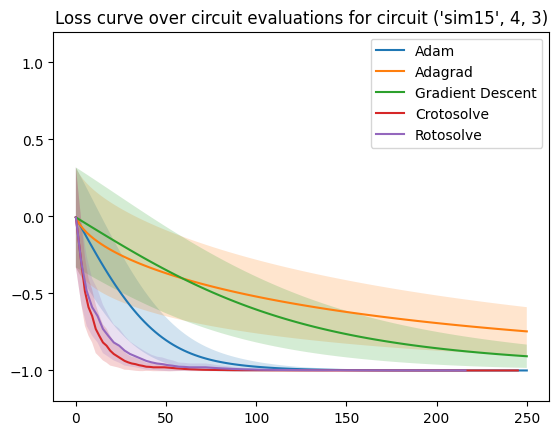

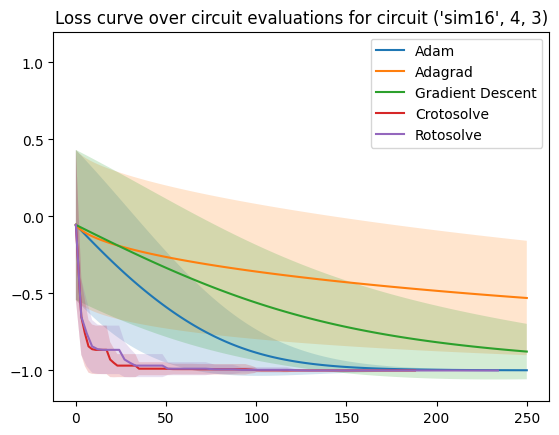

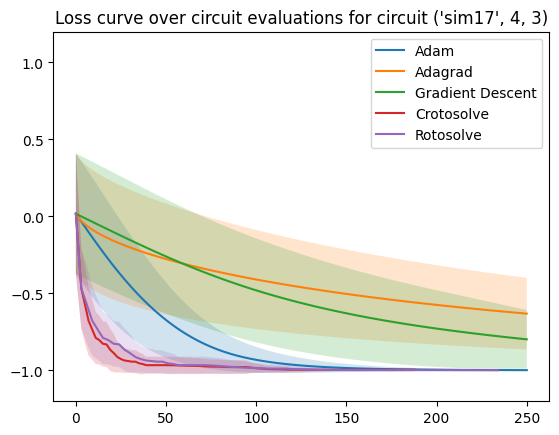

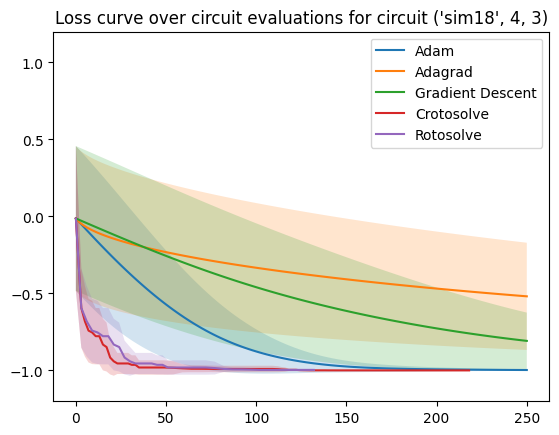

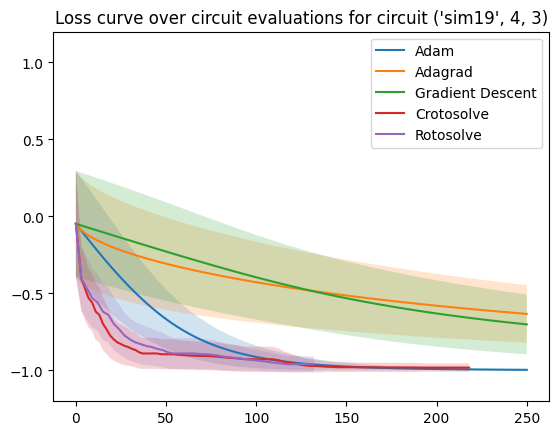

In [4]:
from itertools import groupby
from optimizers import OptimizationResult
import statistics
import matplotlib.pyplot as plt
import os

def get_key(instance: Instance) -> tuple:
    return (
        instance.task.circuit_id,
        instance.task.num_qubits,
        instance.task.num_layers
    )

bigdata = {}
for key, group_instances in groupby(sorted(instances, key=get_key), key=get_key):
    group_instances = list(group_instances)
    print(f"{key}: {len(group_instances)} instances")
    if len(group_instances) < 100:
        continue

    optimizer_names = {
        optimizer
        for instance in group_instances
        for optimizer in instance.results.keys()
    }

    aggregated_results: dict[str, dict[int, list[float]]] = {}
    avg_results: dict[str, dict[int, float]] = {}
    stddev_results: dict[str, dict[int, float]] = {}

    for optimizer_name in optimizer_names:
        loss_curves = [
            dict(instance.results[optimizer_name].loss) # fix my stupid data structure
            for instance in group_instances
        ]

        # for lc in loss_curves:
        #     print(lc)

        evals_keys = {
            evals_key
            for loss_curve in loss_curves
            for evals_key, loss_value in loss_curve.items()
        }

        aggregated_results[optimizer_name] = {
            evals_key: [
                loss_curve[evals_key if evals_key in loss_curve else sorted(loss_curve.keys())[-1]]
                for loss_curve in loss_curves
            ]
            for evals_key in evals_keys
        }

        avg_results[optimizer_name] = {
            evals_key: statistics.mean(aggregated_results[optimizer_name][evals_key])
            for evals_key in evals_keys
        }
        stddev_results[optimizer_name] = {
            evals_key: statistics.stdev(aggregated_results[optimizer_name][evals_key], avg_results[optimizer_name][evals_key])
            for evals_key in evals_keys
        }

    fig, ax = plt.subplots()
    ax.set_ylim(ymin=-1.2,ymax=1.2)
    ax.set_title(f"Loss curve over circuit evaluations for circuit {key}")

    for optimizer_name in optimizer_names:
        x, meany = zip(*sorted(avg_results[optimizer_name].items()))
        x, stddevy = zip(*sorted(stddev_results[optimizer_name].items()))
        ax.plot(x, meany, label=f"{optimizer_name}")

        ax.fill_between(x, [mean - stddev for mean, stddev in zip(meany, stddevy)], [mean + stddev for mean, stddev in zip(meany, stddevy)], alpha=0.2)
    
    ax.legend()
    circuit_id, num_qubits, num_layers = key
    fig.savefig(f"../images/loss-curve_{circuit_id}_{num_qubits}x{num_layers}.pdf", format="pdf")
